In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.mixed_precision import Policy
from google.colab import drive
import cv2
import tensorflow.keras.backend as K

# Enable Mixed Precision
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
base_dir = '/content/drive/MyDrive/health_care_project/extracted_files'
train_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Training_Data')
train_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Training_GroundTruth')
test_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_Data')
test_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_GroundTruth')

# Load images and masks
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            images.append(img)
    return np.array(images)

train_images = load_images_from_folder(train_images_dir)
train_masks = load_images_from_folder(train_masks_dir)
test_images = load_images_from_folder(test_images_dir)
test_masks = load_images_from_folder(test_masks_dir)

# Preprocess data
train_images = train_images / 255.0
train_masks = train_masks / 255.0
train_masks = np.expand_dims(train_masks[:, :, :, 0], axis=3)  # single-channel masks
test_images = test_images / 255.0
test_masks = test_masks / 255.0
test_masks = np.expand_dims(test_masks[:, :, :, 0], axis=3)  # single-channel masks

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

Mounted at /content/drive


In [ ]:
# Define Dice coefficient with proper casting
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype='float32')
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), dtype='float32')
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [ ]:
# Define Residual block
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Define ResUNet model
def res_unet(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = residual_block(layers.Conv2D(64, (3,3), padding='same')(inputs), 64)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = residual_block(layers.Conv2D(128, (3,3), padding='same')(p1), 128)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = residual_block(layers.Conv2D(256, (3,3), padding='same')(p2), 256)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = residual_block(layers.Conv2D(512, (3,3), padding='same')(p3), 512)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = residual_block(layers.Conv2D(256, (3,3), padding='same')(u5), 256)

    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = residual_block(layers.Conv2D(128, (3,3), padding='same')(u6), 128)

    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = residual_block(layers.Conv2D(64, (3,3), padding='same')(u7), 64)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = res_unet()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[MeanIoU(num_classes=2), dice_coef, 'accuracy']
)

# Training the model
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/health_care_project/resunet_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model
test_loss, test_miou, test_dice, test_accuracy = model.evaluate(test_images, test_masks)
print(f'Test Loss: {test_loss}')
print(f'Test Mean IoU: {test_miou}')
print(f'Test Dice Coefficient: {test_dice}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 76s 610ms/step - accuracy: 0.7864 - dice_coef: 0.5784 - loss: 0.4383 - mean_io_u: 0.3624 - val_accuracy: 0.7401 - val_dice_coef: 0.2713 - val_loss: 0.5716 - val_mean_io_u: 0.3713
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9025 - dice_coef: 0.7401 - loss: 0.2483 - mean_io_u: 0.3710 - val_accuracy: 0.7401 - val_dice_coef: 0.1216 - val_loss: 0.7418 - val_mean_io_u: 0.3713
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9225 - dice_coef: 0.7885 - loss: 0.1942 - mean_io_u: 0.3883 - val_accuracy: 0.7400 - val_dice_coef: 0.1462 - val_loss: 0.7028 - val_mean_io_u: 0.3713
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9225 - dice_coef: 0.7943 - loss: 0.1931 - mean_io_u: 0.4203 - val_accuracy: 0.7456 - val_dice_coef: 0.1500 - val_loss: 0.8336 - val_mean_io_u: 0.3713
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9335 - dice_coef: 0.8338 - loss: 0.1626 - mean_io_u: 0.4438 - val_accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


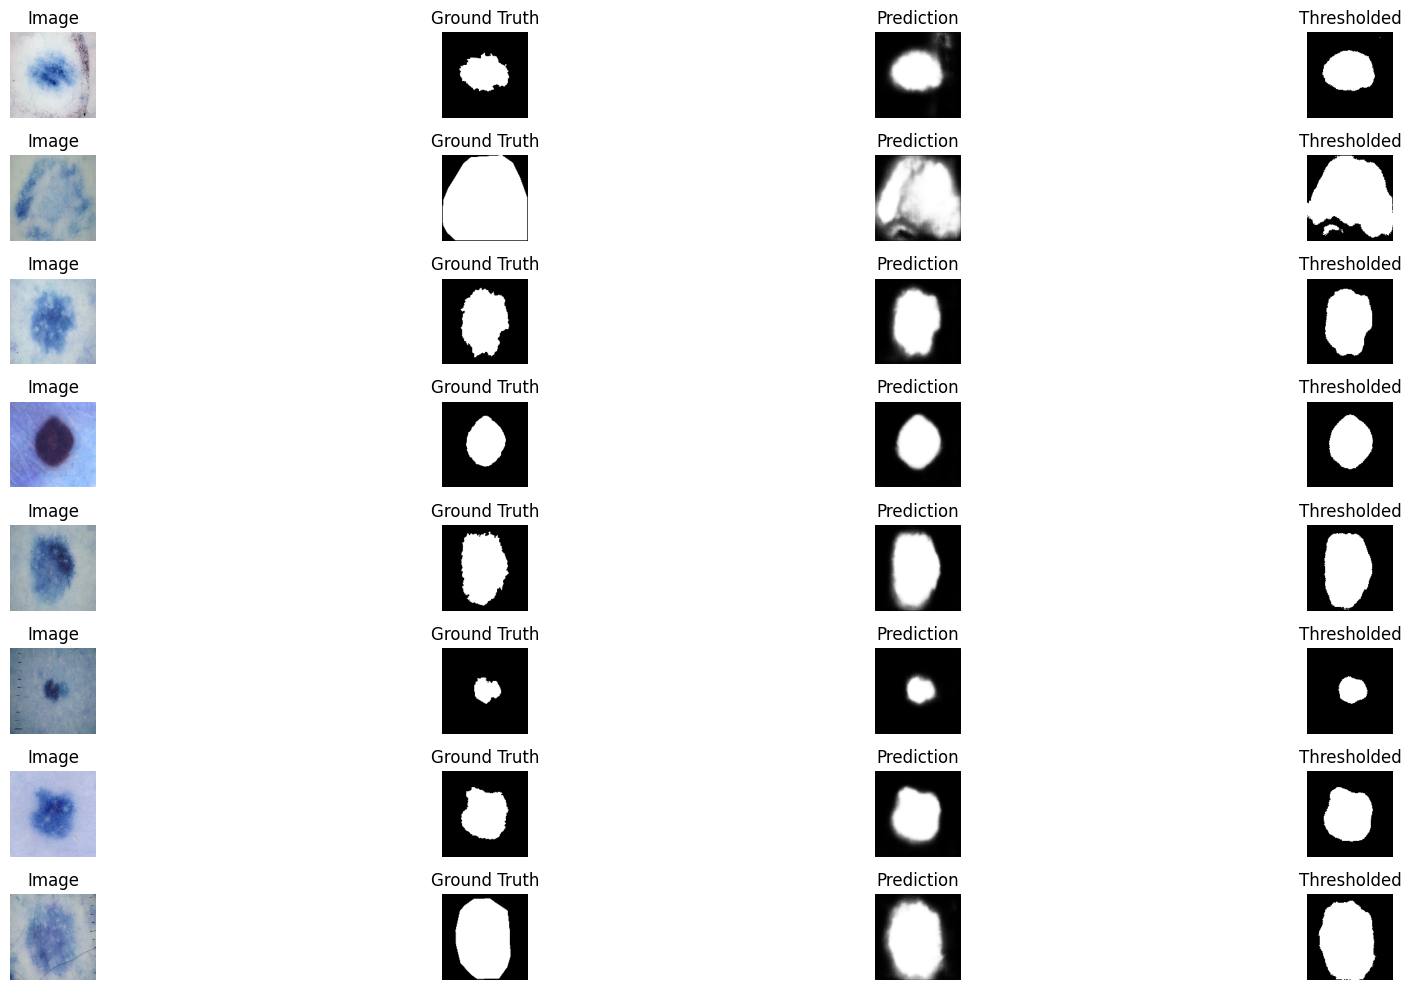

In [ ]:
# Visualize predictions
def display_predictions(images, masks, model, num_images=8):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        idx = np.random.randint(0, images.shape[0])
        image = images[idx]
        mask = masks[idx]
        prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
        prediction_thresholded = (prediction > 0.5).astype(np.float32)

        plt.subplot(num_images, 4, i*4 + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_images, 4, i*4 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_images, 4, i*4 + 3)
        plt.imshow(prediction, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(num_images, 4, i*4 + 4)
        plt.imshow(prediction_thresholded, cmap='gray')
        plt.title('Thresholded')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(test_images, test_masks, model)